In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-02-23 09:55:57.612056: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 09:55:57.686268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 09:55:57.686311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 09:55:57.689041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 09:55:57.701965: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-02-23 09:56:00.176164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 09:56:00.226986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 09:56:00.227180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [7]:
# resize manta and xiris to 224x224
# resize manta with opencv
import cv2
# Define the target size
target_size = (224, 224)

# Create empty lists to store resized images
manta_resized = []
xiris_resized = []

# Loop through each image in manta and xiris
for img_manta, img_xiris in zip(manta, xiris):
    # Resize images using cv2.resize function
    resized_manta = cv2.resize(img_manta, target_size, interpolation=cv2.INTER_LINEAR)
    resized_xiris = cv2.resize(img_xiris, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Append resized images to the respective lists
    manta_resized.append(resized_manta)
    xiris_resized.append(resized_xiris)

In [11]:
# del manta and xiris
del manta
del xiris

In [12]:
# dimensions of MP are the index 1 and 2 of column in feat
dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)
# normalize dim_lh based on max value of each column
dim_lh = dim_lh / max_lh

dim_lh


array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.02666667, 0.03797468],
       ...,
       [0.87111111, 0.48101266],
       [0.87111111, 0.48101266],
       [0.83555556, 0.48101266]])

In [13]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta_resized, axis=3)
xiris = np.expand_dims(xiris_resized, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9587, 224, 224, 2)
y shape:  (9587, 2)


In [14]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 224, 224, 2)
y_train shape:  (7669, 2)
x_test shape:  (1918, 224, 224, 2)
y_test shape:  (1918, 2)


In [15]:
del manta, xiris, y, dim_lh, x

In [ ]:
# install keras_cv
#!pip install keras_cv

In [16]:
# Install Transformer deps from hugging face
try:
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel
except ModuleNotFoundError:
    !pip install transformers
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel

/home/vm/Joao/ssl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim
import tensorflow_similarity.losses as tfsim_losses

In [18]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def get_img_emb(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method="nearest")
    image = tf.transpose(image, [2, 0, 1])  # Channels first
    return image


def data_mapper(img, input_ids, attention_mask):
    return get_img_emb(img), tf.squeeze(input_ids), tf.squeeze(attention_mask)

In [19]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
vision_weights = tf.Variable(model.weights[-2])

2024-02-23 10:04:01.761838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 10:04:01.762735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 10:04:01.763220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
del model
# Clear the Keras backend now that we deleted the original model.
tf.keras.backend.clear_session()

In [21]:
CLIP_vision_model = TFCLIPVisionModel.from_pretrained(
    "openai/clip-vit-base-patch32",
)

CLIP_vision_model.summary()

Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._0/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._7/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._2/layer_norm1/beta:0', 'clip/text_model/encoder/layers_._8/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._2/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._7/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._11/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._3/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._9/layer_norm1/beta:0', 'clip/text_model/encoder/layers_._3/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._6/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._3/layer_norm1/beta:0', 'clip/text_model/encoder/layers_._2/mlp/fc1/kernel:0', 'clip/text_model/encoder/layers_._8/self_attn/k_proj/kernel:0', 'clip/text_model/encoder/layers_._10/la

Model: "tfclip_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPVisionMainLaye  multiple                  87456000  
 r)                                                              
                                                                 
Total params: 87456000 (333.62 MB)
Trainable params: 87456000 (333.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
IMG_SIZE = 224
BATCH_SIZE = 64
COLOR_CHANNELS = 3
N_TOKENS = 77

def get_image_model(n_dims=512):
    x = inputs = tf.keras.layers.Input((COLOR_CHANNELS, IMG_SIZE, IMG_SIZE), name="image")
    x = CLIP_vision_model(x).pooler_output  # pooled CLS states
    kernel_weights = tf.constant_initializer(vision_weights.numpy())
    # Projection layer
    embed = tf.keras.layers.Dense(n_dims, name="image_embedding", kernel_initializer=kernel_weights)(x)
    
    output_l = Dense(1, activation="linear", name="lenght")(embed)
    output_h = Dense(1, activation="linear", name="height")(embed)

    model = tf.keras.models.Model(inputs=inputs, outputs=[output_l, output_h], name="image_model")
    return model

img_model = get_image_model()

img_model.summary()

Model: "image_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 3, 224, 224)]        0         []                            
                                                                                                  
 tfclip_vision_model (TFCLI  TFBaseModelOutputWithPooli   8745600   ['image[0][0]']               
 PVisionModel)               ng(last_hidden_state=(None   0                                       
                             , 50, 768),                                                          
                              pooler_output=(None, 768)                                           
                             , hidden_states=None, atte                                           
                             ntions=None)                                               

In [23]:
# extend X_train and X_test to have 3 channels where the 1st channel is the 3rd channel
X_train = np.concatenate((X_train, X_train[:, :, :, 0:1]), axis=3)
X_test = np.concatenate((X_test, X_test[:, :, :, 0:1]), axis=3)

print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)


x_train shape:  (7669, 224, 224, 3)
x_test shape:  (1918, 224, 224, 3)


In [24]:
# reshape X_train and X_test to shape=(None, 3, 320, 320),
X_train = np.moveaxis(X_train, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

x_train shape:  (7669, 3, 224, 224)
x_test shape:  (1918, 3, 224, 224)


In [25]:
X_test[0:1].shape

(1, 3, 224, 224)

In [27]:
battch_size = 32
epochs = 10
validation_split = 0.2
learning_rate = 0.0001

# compile model
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
img_model.compile(optimizer=optimizer, loss='mse') #, metrics=['mse'])  # Using Mean Squared Error (mse) as the loss
# print model summary
img_model.summary()


# train model
history = img_model.fit(
                    x=X_train,
                    y=[y_train[:, 0], y_train[:, 1]],
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


Model: "image_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 3, 224, 224)]        0         []                            
                                                                                                  
 tfclip_vision_model (TFCLI  TFBaseModelOutputWithPooli   8745600   ['image[0][0]']               
 PVisionModel)               ng(last_hidden_state=(None   0                                       
                             , 50, 768),                                                          
                              pooler_output=(None, 768)                                           
                             , hidden_states=None, atte                                           
                             ntions=None)                                               

2024-02-23 10:06:12.400549: I external/local_xla/xla/service/service.cc:168] XLA service 0x55e2572ba070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 10:06:12.400647: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-23 10:06:12.432575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708682772.717721 2524693 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 [==============================] - 75s 211ms/step - loss: 1.6100 - lenght_loss: 0.2397 - height_loss: 1.3703 - val_loss: 0.3685 - val_lenght_loss: 0.0617 - val_height_loss: 0.3068
Epoch 2/10
192/192 [==============================] - 34s 179ms/step - loss: 2.5325 - lenght_loss: 1.1872 - height_loss: 1.3453 - val_loss: 0.0733 - val_lenght_loss: 0.0605 - val_height_loss: 0.0128
Epoch 3/10
192/192 [==============================] - 35s 184ms/step - loss: 0.0768 - lenght_loss: 0.0617 - height_loss: 0.0151 - val_loss: 0.0786 - val_lenght_loss: 0.0633 - val_height_loss: 0.0153
Epoch 4/10
192/192 [==============================] - 35s 182ms/step - loss: 0.0787 - lenght_loss: 0.0621 - height_loss: 0.0166 - val_loss: 0.1011 - val_lenght_loss: 0.0810 - val_height_loss: 0.0201
Epoch 5/10
192/192 [==============================] - 35s 181ms/step - loss: 0.0796 - lenght_loss: 0.0616 - height_loss: 0.0179 - val_loss: 0.1009 - val_lenght_loss: 0.0793 - val_height_loss: 0.0216
Epoch 6/10
192/1

In [29]:
# evaluate model
score = img_model.evaluate(X_test, [y_test[:, 0], y_test[:, 1]], verbose=0)
print(score)

[0.06681278347969055, 0.040414415299892426, 0.026398368179798126]


60/60 [==============================] - 7s 84ms/step
r2 score:  0.2971854965762222 -1.1838474920990336


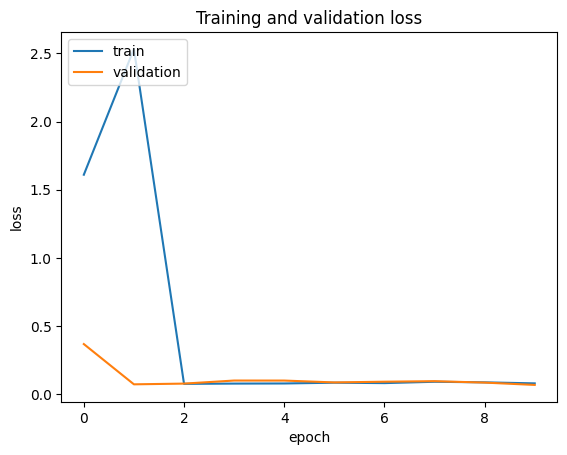

In [31]:
# eval regression model
from sklearn.metrics import r2_score

y_pred_l, y_pred_h = img_model.predict(X_test)
r2_l = r2_score(y_test[:,0], y_pred_l)
r2_h = r2_score(y_test[:,1], y_pred_h)
print("r2 score: ", r2_l, r2_h)

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


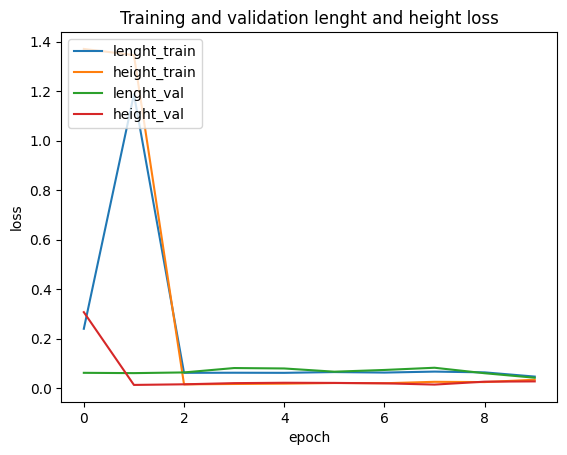

In [32]:
# plot lenght_loss and height_loss during training and validation
plt.plot(history.history['lenght_loss'])
plt.plot(history.history['height_loss'])
plt.plot(history.history['val_lenght_loss'])
plt.plot(history.history['val_height_loss'])
plt.title('Training and validation lenght and height loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['lenght_train', 'height_train', 'lenght_val', 'height_val'], loc='upper left')
plt.show()
 

In [ ]:
# make a black image with the same shape as X_test[0]
black_image = np.zeros(X_test[0].shape[0])
print(black_image.shape)

# replace the second channel with the black image 
X_test_new = np.copy(X_test)
X_test_new[:, :, :, 1] = black_image

""" x = X_test_new[10]
# plot first and second channel of x
plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
 """

(320,)


' x = X_test_new[10]\n# plot first and second channel of x\nplt.imshow(x[:, :, 0])\nplt.show()\nplt.imshow(x[:, :, 1])\nplt.show()\n '

In [ ]:
y_pred_l_new, y_pred_h_new = model.predict(X_test_new)
r2_l_new = r2_score(y_test[:,0], y_pred_l_new)
r2_h_new = r2_score(y_test[:,1], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

60/60 [==============================] - 1s 15ms/step
r2 score:  -7.109014187820108 -16.331621485604416


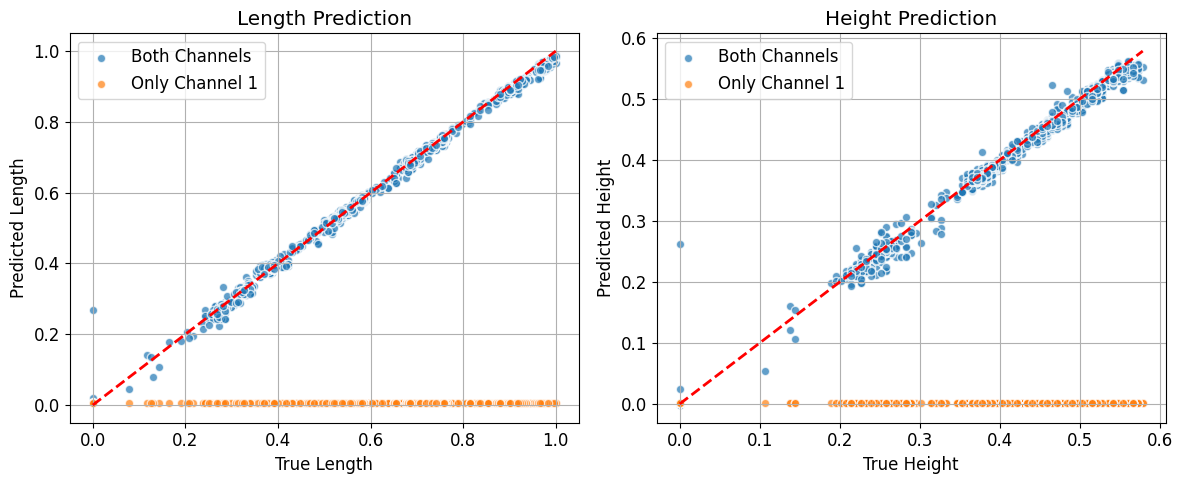

In [ ]:
import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test[:, 0], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test[:, 1], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



60/60 [==============================] - 1s 14ms/step


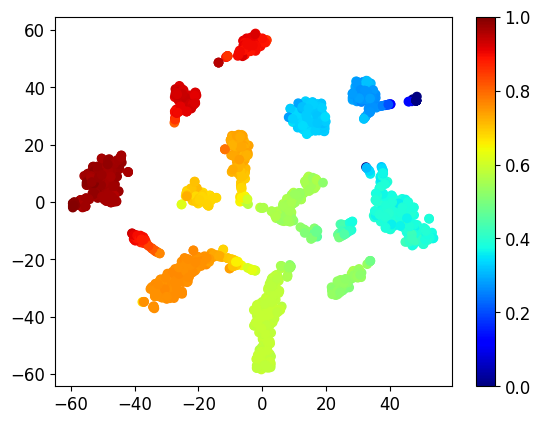

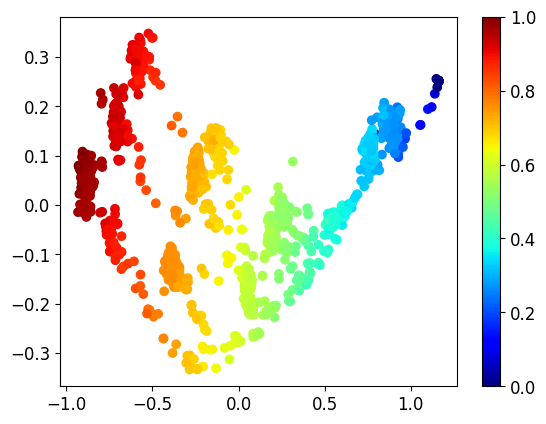

60/60 [==============================] - 1s 13ms/step


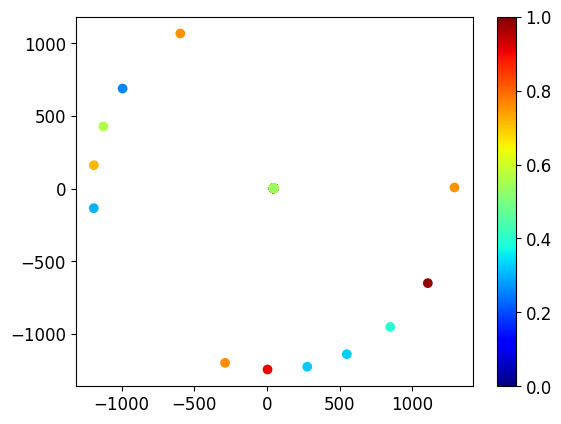

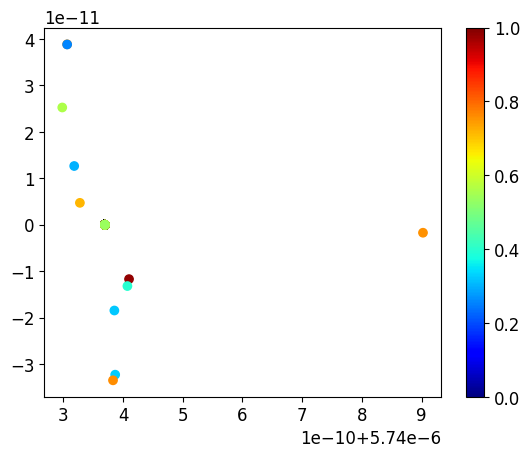

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def eval_tsne_pca(model, x_test, plot=True):
    # Assuming 'model' is your trained regression model and 'data' is your input data
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

tsne_results, pca_results = eval_tsne_pca(model, X_test, plot=True)

# eval for X_test_new
tsne_results, pca_results = eval_tsne_pca(model, X_test_new, plot=True)

    